In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import cv2
import string
import numpy as np
import tensorflow as tf
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Plot properties

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 15.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### ----------------------------------- Functions -----------------------------------

In [3]:
def bbox_threshold(left, top, width, height):
    valid_box = False
    # If the threshold box is less than 30
    if width * height < 30:
        valid_box = False
    elif left == 0 and top == 0 and\
         width == 0 and height == 0:
        valid_box = False
    else:
        valid_box = True

    return valid_box

In [4]:
def bb_intersection_over_union(boxA, boxB):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.

        p1 *-----
           |     |
           |_____* p2

    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [5]:
# Get characters
az = string.ascii_lowercase
AZ = string.ascii_uppercase
nm = string.digits
# Append all characters
all_selections = []
for i in range(len(az)):
    all_selections.append(az[i])
for i in range(len(AZ)):
    all_selections.append(AZ[i])
for i in range(len(nm)):
    all_selections.append(nm[i])
    
def convert_from_category_label(prediction):
    
    return all_selections[prediction]

### ----------------------------------- Captcha Detection ------------------------------

In [6]:
from src.model import Model
from src.data_loader import dataLoader

#### Variables

In [7]:
# Change if needed
print_every      = 1000
batch_size       = 1
max_steps        = 8
lstm_hidden      = 128
pretrained_model = './model/lstm1/model-205'

### Load dataset

In [8]:
# Load train dataset
data = dataLoader(directory='./dataset/captcha', dataset_dir='test',\
                  dataset_name='test.txt', max_steps=6, image_width=200,\
                  image_height=64, grd_attn=False, mode='Test')

All data Loaded!


In [9]:
data.all_data[0]

['55000.png',
 [47, 10, 10, 49, 54],
 [33, 59, 10, 43, 54],
 [20, 102, 10, 37, 41],
 [14, 139, 10, 40, 44],
 [35, 179, 10, 45, 55],
 [35, 224, 10, 47, 55]]

In [10]:
n_iters = data.max_length # Test on all data
#n_iters = 400 # Test on small subset for debug purpose

In [11]:
print(n_iters)

15000


In [12]:
# Load Model
model = Model(dim_feature=[672, 128], dim_hidden=128, n_time_step=8,
              alpha_c=1.0, image_height=64, image_width=200, mode='Test')
# Build model for inference
pred_bboxs_, alpha_list_ = model.build_test_model()

CNN build model sucess!


In [13]:
## Run FeedForward

# Collect predictions from runs for viz
vis_images  = []
attn_images = []
pred_bboxes = []
grnd_bboxes = []
grnd_labels = []
# Test Data Loader
test_gen = data.gen_data_batch(batch_size)

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if pretrained_model is not None:
        print("Start testing with pretrained Model..")
        saver.restore(sess, pretrained_model)
    else:
        print("Start testing with Model with random weights...")

    for i in range(n_iters):
        image_batch, grd_lables_batch, image_batch_norm, grd_bboxes_batch = next(test_gen)
        feed_dict = {model.images: image_batch_norm,
                     model.drop_prob: 1.0}
        prediction_bboxes, prediction_alpha = sess.run([pred_bboxs_, alpha_list_], feed_dict)
        
        vis_images.append(image_batch)
        attn_images.append(prediction_alpha)
        pred_bboxes.append(prediction_bboxes)
        grnd_bboxes.append(grd_bboxes_batch)
        grnd_labels.append(grd_lables_batch)
        
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close session
sess.close()

Start testing with pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/lstm1/model-205
Inference Completion..{0/15000}
Inference Completion..{1000/15000}
Inference Completion..{2000/15000}
Inference Completion..{3000/15000}
Inference Completion..{4000/15000}
Inference Completion..{5000/15000}
Inference Completion..{6000/15000}
Inference Completion..{7000/15000}
Inference Completion..{8000/15000}
Inference Completion..{9000/15000}
Inference Completion..{10000/15000}
Inference Completion..{11000/15000}
Inference Completion..{12000/15000}
Inference Completion..{13000/15000}
Inference Completion..{14000/15000}
Inference Completion..{15000/15000}
Completed!


In [14]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))
print(len(grnd_labels))

15000
15000
15000
15000
15000


In [15]:
pred_bboxes[0][0].shape

(1, 4)

In [16]:
grnd_labels[0][0]

array([47, 33, 20, 14, 35, 35])

### Compute sequence IOU accuracy

In [17]:
count = 0.0
final_IOU_score = 0.0

In [18]:
for t in range(n_iters):
    sample_seq = 0.0
    sample_iou = 0.0
    for T in range(1, 7, 1):
        ## Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]
        
        ## Predicted
        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1]) 
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])
        
        vld_bbox_prd = bbox_threshold(left=sample_left, top=sample_top,\
                                width=sample_width, height=sample_heigt)

        vld_bbox_grd = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                width=sample_width_grd, height=sample_heigt_grd)
        
        if vld_bbox_grd:
            sample_seq += 1
            if vld_bbox_prd:
                # Predicted
                sample_right = sample_left + sample_width
                sample_down  = sample_top  + sample_heigt
                # Ground truth
                sample_right_grd = sample_left_grd + sample_width_grd
                sample_down_grd  = sample_top_grd  + sample_heigt_grd

                boxA = (sample_left, sample_top, sample_right, sample_down)
                boxB = (sample_left_grd, sample_top_grd, sample_right_grd, sample_down_grd)

                sample_iou += bb_intersection_over_union(boxA, boxB)
    if i%print_every == 0:
        print('Inference Completion..{%d/%d}' % (t, n_iters))
    final_IOU_score += sample_iou/sample_seq
    count += 1.0
#-----------------------------------------------------
print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
print('Completed!')

Inference Completion..{15000/15000}
Completed!


In [19]:
print('Final Sequence IOU score = ', np.ceil((final_IOU_score/count)*100), '%')

Final Sequence IOU score =  89.0 %


### BBox Visualization

In [20]:
shift_viz = 500

In [21]:
attn_images[0][0].shape

(1, 672)

In [22]:
## Upscale attention mask
upscaled_attn_images = []
for k in range(0, n_iters, shift_viz):
    sample_attention_res_interm = []
    for K in range(1, 7, 1):
        sample_attn_reshaped = np.reshape(attn_images[k][K], (14, 48))
        sample_attention_res = skimage.transform.pyramid_expand(sample_attn_reshaped, upscale=4.55, sigma=1, multichannel=False)
        sample_attention_res_interm.append(sample_attention_res)
    
    upscaled_attn_images.append(sample_attention_res_interm)

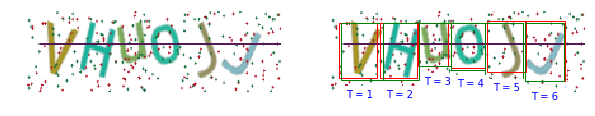

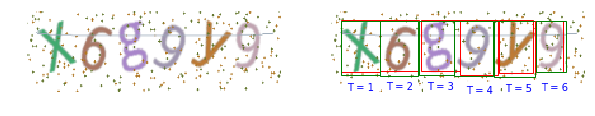

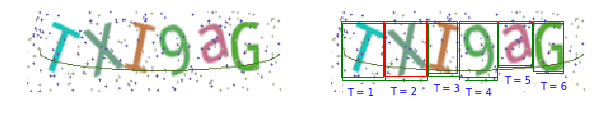

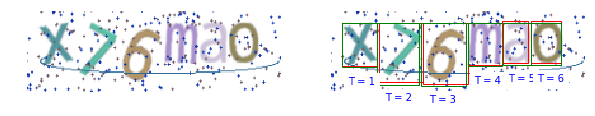

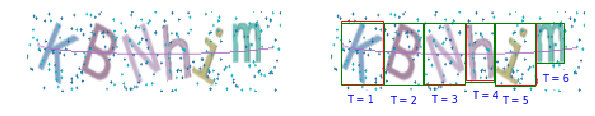

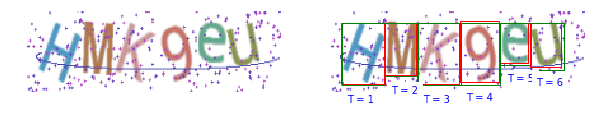

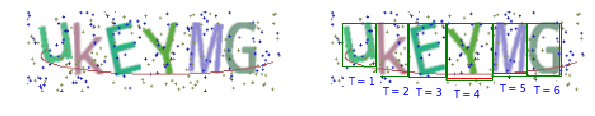

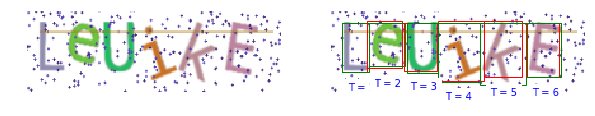

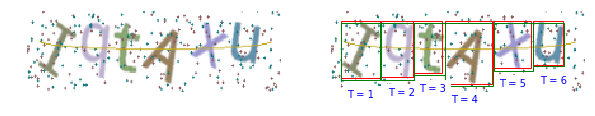

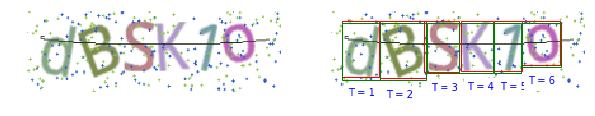

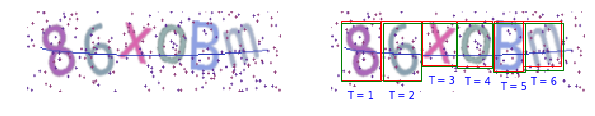

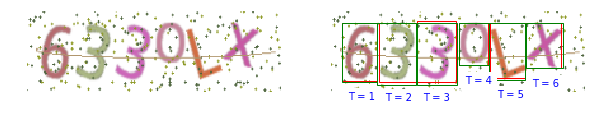

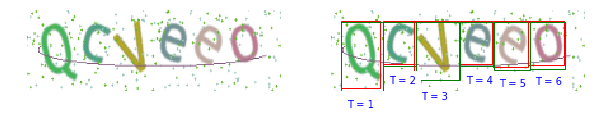

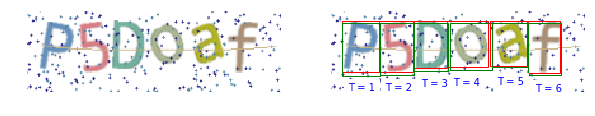

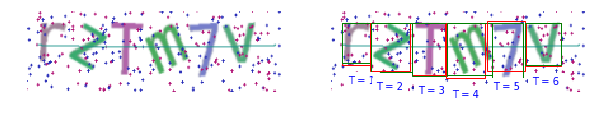

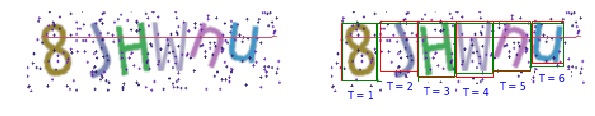

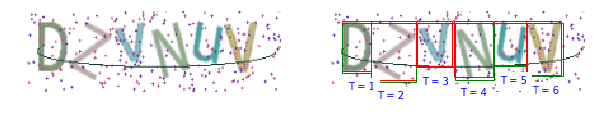

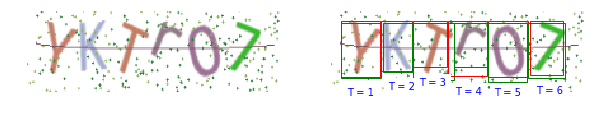

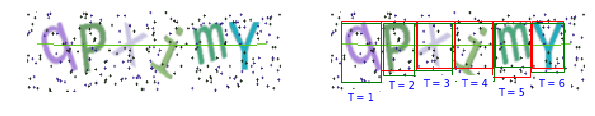

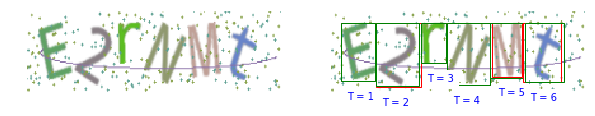

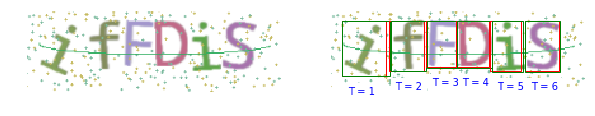

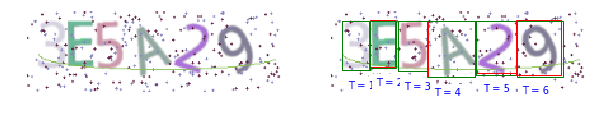

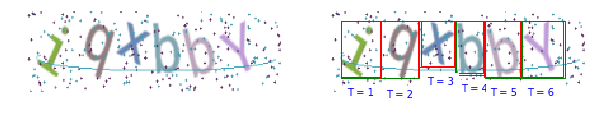

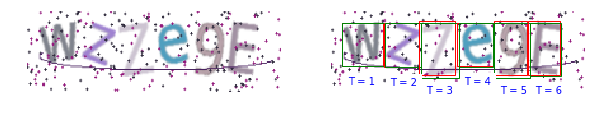

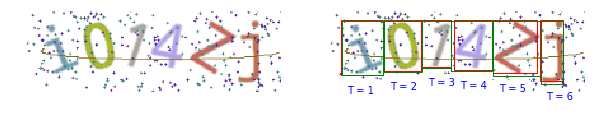

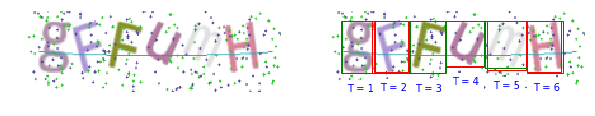

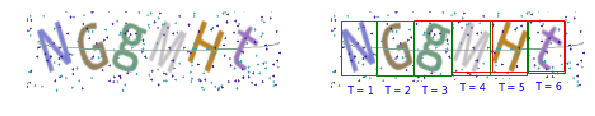

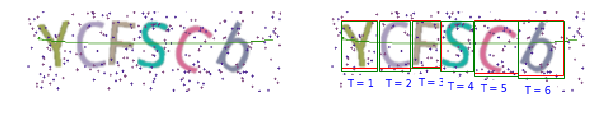

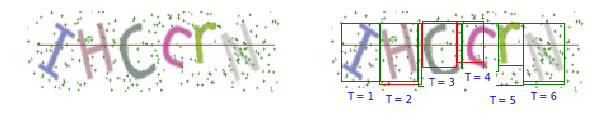

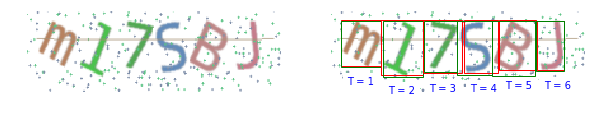

In [23]:
for t in range(0, n_iters, shift_viz):
    # Plot original image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(vis_images[t][0])
    ax[0].axis('off')
    ax[1].imshow(vis_images[t][0])
    for T in range(1, 7, 1):
        # ax[1].imshow(upscaled_attn_images[count][T], alpha=0.5)
        
        # Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]

        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1])
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])
                
        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  
        
        #ax[T+1].text(0, 1, (int(sample_left), int(sample_top), int(sample_width), int(sample_heigt)), color='black', backgroundcolor='white', fontsize=7)
        #ax[T+1].text(0, 56, 'iou: ' + str(np.round(iou_sample, decimals=3)), color='black', backgroundcolor='white', fontsize=7)
        text_x = int(sample_left + 5)
        text_y = int(sample_top + sample_heigt + 15)
        ax[1].text(text_x, text_y, 'T = ' + str(T), color='blue', backgroundcolor='white', fontsize=10)
        ax[1].add_patch(rect1)
        ax[1].add_patch(rect2)
        ax[1].axis('off')
        
    plt.show()

### ------------------------------ Digit Classification -----------------------------------

In [24]:
# Load classifier dataset
from src.data_loader import dataLoader

In [25]:
data = dataLoader(directory='./dataset/captcha', dataset_dir='test',\
                  dataset_name='test.txt', max_steps=6, image_width=200,\
                  image_height=64, grd_attn=False, mode='test')

All data Loaded!


In [26]:
viz = True
pretrained_clfy_model='./model/clsfy1/model-101'

In [27]:
#del Clfy_Model # -- Uncomment if re-running without restarting the kernel

In [28]:
from src.model_classify import Model_Classify as Clfy_Model

In [29]:
# Reset graph
tf.reset_default_graph()
# Load
clfy_model = Clfy_Model(image_height=54, image_width=54, mode='test')
# Predictions
predictions  = clfy_model.build_test_model()

(?,)
CNN build model sucess!


### Compute sequence digit prediction accuracy

In [30]:
count = 0.0
final_seq_acc_grd = 0.0
final_seq_acc_prd = 0.0

In [31]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))

15000
15000
15000
15000


In [33]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    # To load
    saver = tf.train.Saver()
    # Load pretrained model
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    # Run predictions
    for t in range(n_iters):
        # Get image
        test_image = vis_images[t][0]
        sample_cnt = 0
        sample_seq = len(grnd_labels[t][0])
        sample_acc_grd = 0.0
        sample_acc_prd = 0.0
        # Loop through steps
        for T in range(1, max_steps-1):
            # Label
            sample_label = grnd_labels[t][0][T-1]
            
            # Predicted
            sample_left  = int(pred_bboxes[t][T][0][0])
            sample_top   = int(pred_bboxes[t][T][0][1])
            sample_width = int(pred_bboxes[t][T][0][2])
            sample_heigt = int(pred_bboxes[t][T][0][3])

            vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
                                      width=sample_width, height=sample_heigt)
                 
            if vld_bbox:
                pred_extract_img = test_image[sample_top:sample_top+sample_heigt, sample_left:sample_left+sample_width, :]
                pred_extract_img = cv2.resize(pred_extract_img, (54, 54), interpolation = cv2.INTER_LINEAR)
                pred_extract_img_norm = pred_extract_img/127.5 - 1.0
                pred_extract_img_norm = np.expand_dims(pred_extract_img_norm, axis=0) # [1, H, W, C]
                
            #--------------------------------------------------
            # Ground
            sample_left_grd  = int(grnd_bboxes[t][0][T][0])
            sample_top_grd   = int(grnd_bboxes[t][0][T][1])
            sample_width_grd = int(grnd_bboxes[t][0][T][2])
            sample_heigt_grd = int(grnd_bboxes[t][0][T][3])
            
            vld_grd_bbox = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                      width=sample_width_grd, height=sample_heigt_grd)
            
            # Ground
            if vld_grd_bbox:
                exact_img = test_image[sample_top_grd:sample_top_grd+sample_heigt_grd, sample_left_grd:sample_left_grd+sample_width_grd, :]
                exact_img = cv2.resize(exact_img, (54, 54), interpolation = cv2.INTER_LINEAR)
                exact_img_norm = exact_img/127.5 - 1.0
                exact_img_norm = np.expand_dims(exact_img_norm, axis=0) # [1, H, W, C]
                feed_dict  = {clfy_model.images: exact_img_norm,
                              clfy_model.drop_prob: 1.0}
                pred_exact = sess.run(predictions, feed_dict)
                
                if int(pred_exact[0]) == int(sample_label) and sample_cnt < sample_seq:
                    sample_acc_grd += 1.0
                
                # Predictions
                if vld_grd_bbox and vld_bbox:
                    feed_dict = {clfy_model.images: pred_extract_img_norm,
                                 clfy_model.drop_prob: 1.0}
                    pred = sess.run(predictions, feed_dict)
                    
                    if int(pred[0]) == int(sample_label) and sample_cnt < sample_seq:
                        sample_acc_prd += 1.0
                
                # Update
                sample_cnt += 1
                
        final_seq_acc_grd += sample_acc_grd/sample_seq
        final_seq_acc_prd += sample_acc_prd/sample_seq
        
        if t%print_every == 0:
            print('Inference Completion..{%d/%d}' % (t, n_iters))
        count += 1.0
#-----------------------------------------------------
print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
print('Completed!')

Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy1/model-101
Inference Completion..{0/15000}
Inference Completion..{1000/15000}
Inference Completion..{2000/15000}
Inference Completion..{3000/15000}
Inference Completion..{4000/15000}
Inference Completion..{5000/15000}
Inference Completion..{6000/15000}
Inference Completion..{7000/15000}
Inference Completion..{8000/15000}
Inference Completion..{9000/15000}
Inference Completion..{10000/15000}
Inference Completion..{11000/15000}
Inference Completion..{12000/15000}
Inference Completion..{13000/15000}
Inference Completion..{14000/15000}
Inference Completion..{15000/15000}
Completed!


In [34]:
print('Ground  Sequence Classification Accuracy: ', np.round((final_seq_acc_grd/count), 4) * 100, '%')
print('Predict Sequence Classification Accuracy: ', np.round((final_seq_acc_prd/count), 4) * 100, '%')

Ground  Sequence Classification Accuracy:  99.98 %
Predict Sequence Classification Accuracy:  89.79 %


### Digit Prediction Accuracy

Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy1/model-101


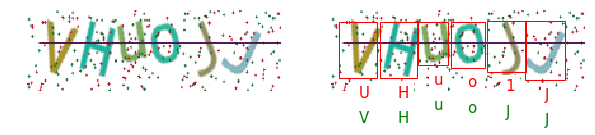

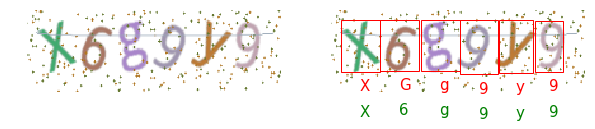

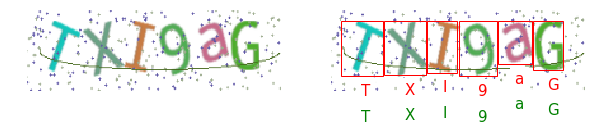

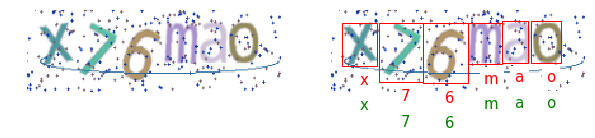

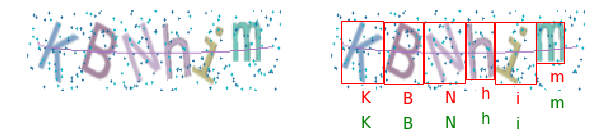

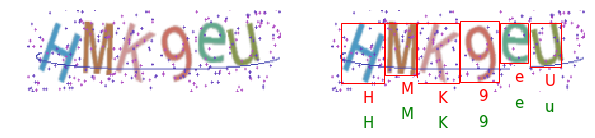

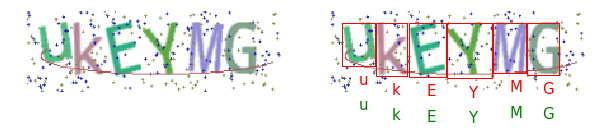

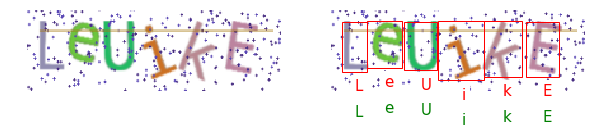

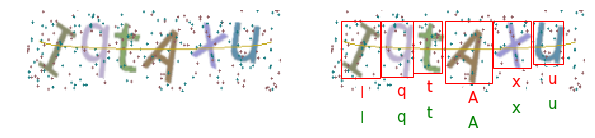

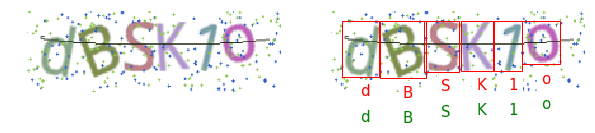

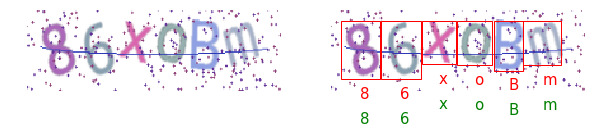

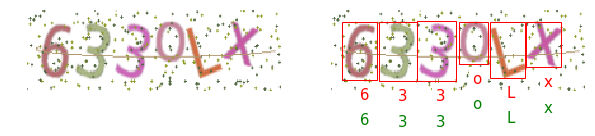

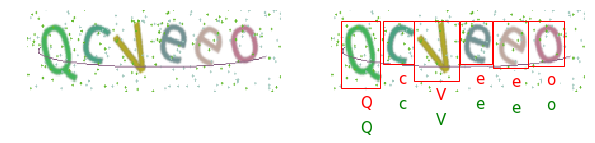

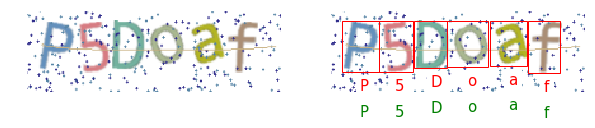

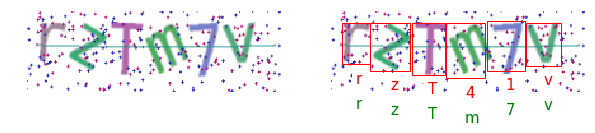

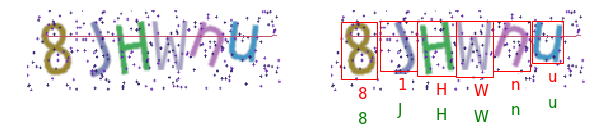

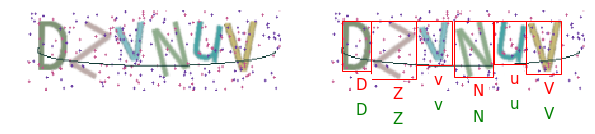

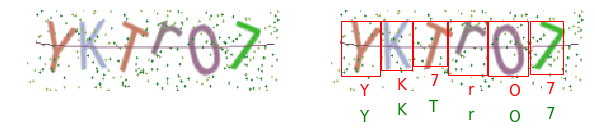

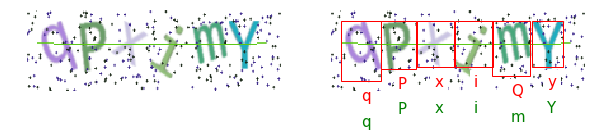

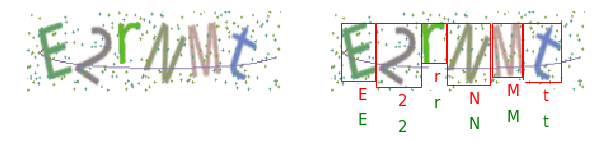

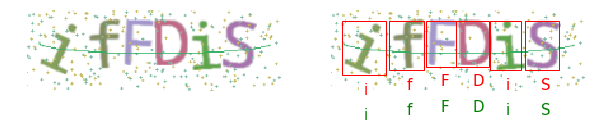

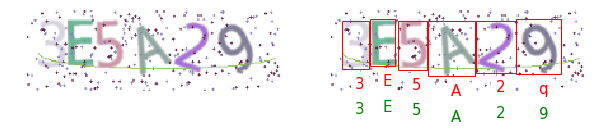

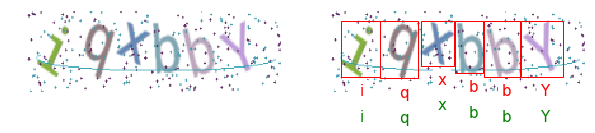

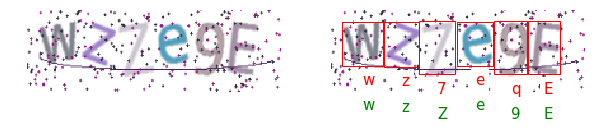

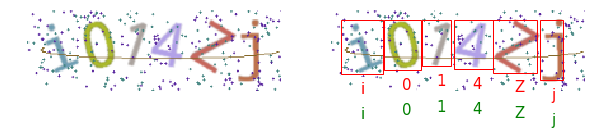

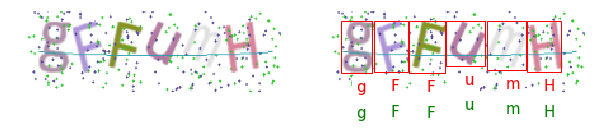

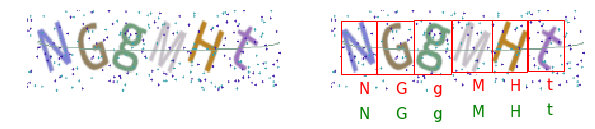

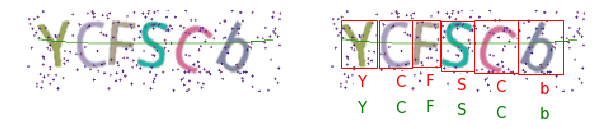

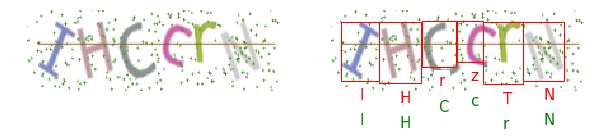

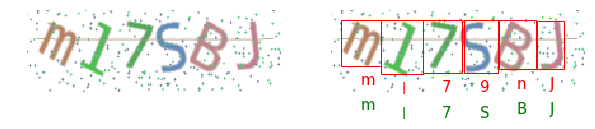

In [35]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    # To load
    saver = tf.train.Saver()
    # Load pretrained model
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    # Run predictions
    for t in range(0, n_iters, shift_viz):
        # Get image
        test_image = vis_images[t][0]
        # Valid predictions
        valid_pred     = []
        valid_pred_bbx = []
        predt_pred     = []
        grund_pred     = []
        grund_pred_bbx = []
        num_valid_pred = 0
        num_valid_grnd_pred = 0
        # Loop through steps
        for T in range(max_steps):
            # Predicted
            sample_left  = int(pred_bboxes[t][T][0][0])
            sample_top   = int(pred_bboxes[t][T][0][1])
            sample_width = int(pred_bboxes[t][T][0][2])
            sample_heigt = int(pred_bboxes[t][T][0][3])

            
            vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
                                      width=sample_width, height=sample_heigt)
                 
            if vld_bbox:
                extract_img = test_image[sample_top:sample_top+sample_heigt, sample_left:sample_left+sample_width, :]
                extract_img = cv2.resize(extract_img, (54, 54), interpolation = cv2.INTER_LINEAR)
                extract_img_norm = extract_img/127.5 - 1.0
                extract_img_norm = np.expand_dims(extract_img_norm, axis=0) # [1, H, W, C]
                # Predictions
                feed_dict = {clfy_model.images: extract_img_norm,
                             clfy_model.drop_prob: 1.0}
                pred = sess.run(predictions, feed_dict)
                predt_pred.append(pred)
                valid_pred_bbx.append([sample_left, sample_top, sample_width, sample_heigt])
                valid_pred.append(pred)
                num_valid_pred += 1
            #--------------------------------------------------
            # Ground
            sample_left_grd  = int(grnd_bboxes[t][0][T][0])
            sample_top_grd   = int(grnd_bboxes[t][0][T][1])
            sample_width_grd = int(grnd_bboxes[t][0][T][2])
            sample_heigt_grd = int(grnd_bboxes[t][0][T][3])
            
            vld_grd_bbox = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                      width=sample_width_grd, height=sample_heigt_grd)
            
            if vld_grd_bbox:
                exact_img = test_image[sample_top_grd:sample_top_grd+sample_heigt_grd, sample_left_grd:sample_left_grd+sample_width_grd, :]
                exact_img = cv2.resize(exact_img, (54, 54), interpolation = cv2.INTER_LINEAR)
                exact_img_norm = exact_img/127.5 - 1.0
                exact_img_norm = np.expand_dims(exact_img_norm, axis=0) # [1, H, W, C]
                # Predictions
                feed_dict  = {clfy_model.images: exact_img_norm,
                              clfy_model.drop_prob: 1.0}
                pred_exact = sess.run(predictions, feed_dict)
                grund_pred.append(pred_exact)
                grund_pred_bbx.append([sample_left_grd, sample_top_grd, sample_width_grd, sample_heigt_grd]) 
                num_valid_grnd_pred += 1
    
        if viz:
            # Plot original image
            fig,ax = plt.subplots(1, 2)
            ax[0].imshow(vis_images[t][0])
            ax[0].axis('off')
            ax[1].imshow(vis_images[t][0])
            for T in range(len(valid_pred_bbx)):                
                # Ground
                # sample_left  = grund_pred_bbx[T]
                # sample_top   = grund_pred_bbx[T]
                # sample_width = grund_pred_bbx[T]
                # sample_heigt = grund_pred_bbx[T]
                # rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  
                # ax[1].add_patch(rect2)

                sample_left  = valid_pred_bbx[T][0]
                sample_top   = valid_pred_bbx[T][1]
                sample_width = valid_pred_bbx[T][2]
                sample_heigt = valid_pred_bbx[T][3]

                rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  

                text_x = int((sample_left + (sample_left + sample_width)) / 2)
                text_y = int(sample_top + sample_heigt + 15)
                ax[1].text(text_x, text_y,    str(convert_from_category_label(prediction=predt_pred[T][0])), color='red', backgroundcolor='white', fontsize=15)
                ax[1].text(text_x, text_y+20, str(convert_from_category_label(prediction=grund_pred[T][0])), color='green', backgroundcolor='white', fontsize=15)
                ax[1].add_patch(rect1)
                ax[1].axis('off')
                
            plt.show()